In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
from geopy.distance import vincenty

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [3]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [4]:
path = '/Volumes/RT&O/C Brace/GPS Analysis/' #mac
# path = 'X:/C Brace/GPS Analysis/' #win
path = 'X:/C Brace/GPS Analysis/'


## Add LandUse coordinates and weartime to UIC preprocessed GPS files

In [ ]:
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

In [36]:
GpsDates[:10]

0   2015-02-10 17:42:37
1   2015-02-10 17:42:47
2   2015-02-10 17:42:57
3   2015-02-10 17:43:07
4   2015-02-10 17:43:17
5   2015-02-10 17:43:27
6   2015-02-10 17:43:37
7   2015-02-10 17:43:47
8   2015-02-10 17:43:57
9   2015-02-10 17:44:07
dtype: datetime64[ns]

In [83]:
#load single file - TEST
fraw = 'CBR08_CBrace.csv'
fuic = 'CBR08_Final_Summary_File.xlsx'
Gpsdata = pd.read_csv(path+'GPSWT/'+fraw)
Baseline = pd.read_excel(path+'UIC_GPSData/'+fuic,sheetname='CBR')


loc_lat = [];    loc_lon = [];  wear_frac = []; num_points = []
spd_min = []; spd_max = []; spd_mean = []; spd_median = []
duration = []; gap_min = [];  gap_max = []; gap_mean = []; gap_median = [] 


#Drop unnecessary cols from UIC table
Baseline = Baseline.drop(['MeanSpeed','Numberpoints','Duration','TotalGap'],axis=1)
print(Baseline.head())

#convert date formats from raw gps
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

for i in range(len(Baseline)):
    if i%(len(Baseline)/10) == 0:
        print(str(i)+'%')
    start = Baseline.BeginTime[i]
    end = Baseline.EndTime[i]
    d = Baseline.Date[i]

    if type(d) != str:
        d = d.strftime('%Y/%m/%d') 
    if type(start) != str:
        start = str(start)
    if type(end) != str:
        end = str(end)
    try:
        startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
        enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
    except(ValueError):
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
            except(ValueError):
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


    #find matching dates between 2 files (processed and raw) and compute features
    ind = (GpsDates >= startdate) & (GpsDates <= enddate)
    #compute and store features
    meanLat = np.mean(Gpsdata['LATITUDE'][ind])
    meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
    if np.isnan(meanLat) or np.isnan(meanLon):
        print('null found %s'%any(ind))
        print(startdate,enddate)
    loc_lat.append(meanLat)
    loc_lon.append(meanLon)
    spd_min.append(np.min(Gpsdata['SPEED'][ind]))
    spd_max.append(np.max(Gpsdata['SPEED'][ind]))                
    spd_mean.append(np.mean(Gpsdata['SPEED'][ind]))
    spd_median.append(np.median(Gpsdata['SPEED'][ind]))
    num_points.append(sum(ind))
    duration.append(enddate-startdate)
    #gaps between points in secs in rawgps data for daterange
    td = GpsDates[ind].diff()
    gap_min.append(td.min().total_seconds())
    gap_max.append(td.max().total_seconds())
    gap_mean.append(td.mean().total_seconds())
    gap_median.append(td.median().total_seconds())

    wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
    wear_frac.append(sum(wear_ind)/sum(ind))

Baseline['Mean Lat'] = loc_lat; Baseline['Mean Lon'] = loc_lon; Baseline['Wear Frac'] = wear_frac
Baseline['Duration'] = duration; Baseline['Numpoints'] = num_points
Baseline['Speed_Mean'] = spd_mean; Baseline['Speed_Min'] = spd_min; Baseline['Speed_Max'] = spd_max
Baseline['Speed_Median'] = spd_median
Baseline['Gap_Min'] = gap_min; Baseline['Gap_Max']=gap_max; Baseline['Gap_Mean']=gap_mean; 
Baseline['Gap_Median']=gap_median


# Compute Min, Max, Median, Mean of speed
# Compute duration
# Number of Raw GPS points
# Min, Max, mean, std of gaps b/w points

# Number of unclustered data points for each Subject/Brace

        Date  Sequence BeginTime   EndTime Mode     LandUse
0 2015-02-10         1  11:42:37  12:09:58  Car        Trip
1 2015-02-10         2  12:10:08  12:17:18  NaN  COM_URBMIX
2 2015-02-10         3  12:17:28  12:36:28  Car        Trip
3 2015-02-10         4  12:36:38  12:45:38  NaN  COM_URBMIX
4 2015-02-10         5  12:45:48  13:55:10  Car        Trip
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [84]:
Baseline.head()

,Date,Sequence,BeginTime,EndTime,Mode,LandUse,Mean Lat,Mean Lon,Wear Frac,Duration,Numpoints,Speed_Mean,Speed_Min,Speed_Max,Speed_Median,Gap_Min,Gap_Max,Gap_Mean,Gap_Median
0,2015-02-10,1,11:42:37,12:09:58,Car,Trip,41.870200,87.711023,1,00:27:21,165,46.940548,0.163532,109.548119,47.974251,10.0,11.0,10.006098,10.0
1,2015-02-10,2,12:10:08,12:17:18,NaN,COM_URBMIX,41.830436,87.803025,1,00:07:10,44,2.284377,0.047465,32.243301,0.642872,10.0,10.0,10.000000,10.0
2,2015-02-10,3,12:17:28,12:36:28,Car,Trip,41.839046,87.767186,1,00:19:00,115,20.067299,0.019340,66.380928,21.266867,10.0,10.0,10.000000,10.0
3,2015-02-10,4,12:36:38,12:45:38,NaN,COM_URBMIX,41.851519,87.747862,1,00:09:00,55,1.562509,0.004843,15.570488,0.511654,10.0,10.0,10.000000,10.0
4,2015-02-10,5,12:45:48,13:55:10,Car,Trip,41.872845,87.685020,1,01:09:22,379,26.829532,0.089908,98.430122,21.596622,10.0,123.0,11.010582,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118bb82d0>], dtype=object)

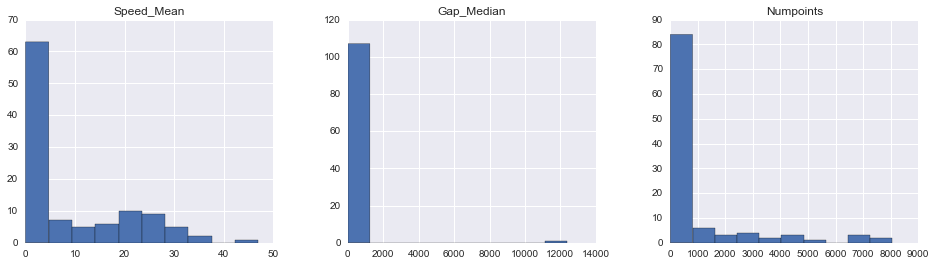

In [99]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
Baseline[['Speed_Mean']].hist(ax=ax)
ax = fig.add_subplot(132)
Baseline[['Gap_Median']].hist(ax=ax)
ax = fig.add_subplot(133)
Baseline[['Numpoints']].hist(ax=ax)


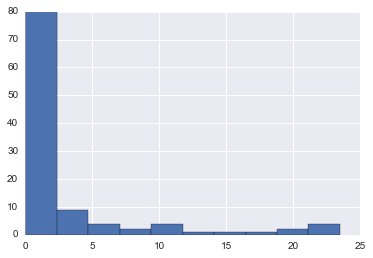

In [121]:
Baseline['Duration'].apply(lambda x: x.total_seconds()/60/60).hist()

In [23]:
dt.timedelta(days=1)

datetime.timedelta(1)

In [25]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_latlonwear(Baseline,Gpsdata,GpsDates):
    loc_lat = [];    loc_lon = [];     wear_frac = []
    spd_min = []; spd_max = []; spd_mean = []; spd_median = []
    duration = []; num_points = []; gap_min = [];  gap_max = []; gap_mean = []; gap_median = [] 
    

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


        #find matching dates between 2 files (processed and raw) and compute features
        ind = (GpsDates >= startdate) & (GpsDates <= enddate)
        # track clustered points
        if i<1:
            UsedPoints = ind
        else:
            UsedPoints = UsedPoints | ind
                
        meanLat = np.mean(Gpsdata['LATITUDE'][ind])
        meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
        
        if np.isnan(meanLat) or np.isnan(meanLon):
            print('null found %s'%any(ind))
            print(startdate,enddate)
        loc_lat.append(meanLat)
        loc_lon.append(meanLon)

        spd_min.append(np.min(Gpsdata['SPEED'][ind]))
        spd_max.append(np.max(Gpsdata['SPEED'][ind]))                
        spd_mean.append(np.mean(Gpsdata['SPEED'][ind]))
        spd_median.append(np.median(Gpsdata['SPEED'][ind]))
        num_points.append(sum(ind))
        duration.append((enddate-startdate)/dt.timedelta(days=1))
        #gaps between points in secs in rawgps data for daterange
        td = GpsDates[ind].diff()
        gap_min.append(td.min().total_seconds())
        gap_max.append(td.max().total_seconds())
        gap_mean.append(td.mean().total_seconds())
        gap_median.append(td.median().total_seconds())
        
        wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
        wear_frac.append(sum(wear_ind)/sum(ind))

    Baseline['Mean Lat'] = loc_lat
    Baseline['Mean Lon'] = loc_lon
    Baseline['Wear Frac'] = wear_frac
    Baseline['Duration'] = duration; Baseline['Numpoints'] = num_points
    Baseline['Speed_Mean'] = spd_mean; Baseline['Speed_Min'] = spd_min; Baseline['Speed_Max'] = spd_max
    Baseline['Speed_Median'] = spd_median
    Baseline['Gap_Min'] = gap_min; Baseline['Gap_Max']=gap_max; Baseline['Gap_Mean']=gap_mean; 
    Baseline['Gap_Median']=gap_median

    
    print(str(sum(~UsedPoints)) + ', ' + str(sum(~UsedPoints)/len(UsedPoints)))
    # Compute Min, Max, Median, Mean of speed
    # Compute duration
    # Number of Raw GPS points
    # Min, Max, mean, std of gaps b/w points
    
    # Number of unclustered data points for each Subject-Brace

# Loop through files and add Lat, Lon and Wear Time to UIC files

In [100]:
fwt = os.listdir(path+'GPSWT/')
fconv = os.listdir(path+'UIC_GPSData/w_LatLonWear/')

for f in list(set(fwt)-set(fconv)):
    try:
        #load files
        print(f)
        Gpsdata = pd.read_csv(path+'GPSWT/'+f)
        #include long sign
        lonsgn = np.cos((Gpsdata['E/W']=='W')*np.pi)
        Gpsdata['LONGITUDE'] = Gpsdata['LONGITUDE']*lonsgn
        Subjid = f[:5]
        trial = f[6] #cbrace,SCO or baseline
        switcher = {'C':'CBR','S':'SCO','B':'Baseline'}
        UICdata = pd.read_excel(path+'UIC_GPSData/'+Subjid+'_Final_Summary_File.xlsx',sheetname=switcher[trial])
        
        #convert date formats from raw gps
        x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
        GpsDates = string2datetime(x) #convert to datetime object
        GpsDates=pd.Series(GpsDates)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_latlonwear(UICdata,Gpsdata,GpsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    except(FileNotFoundError):
        print('File not found')

CBR22_Baseline.csv
20086, 0.387028401865


In [33]:
fconv =  os.listdir(path+'GPSWT/')

for f in fconv:
    print(f)
    Data = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    print(len(np.unique(np.array(Data['Date']))))

CBR08_CBrace.csv
23
CBR08_SCO.csv
18
CBR11_Baseline.csv
43
CBR11_CBrace.csv
26
CBR11_SCO.csv
3
CBR15_Baseline.csv
25
CBR15_CBrace.csv
6
CBR15_SCO.csv
13
CBR16_CBrace.csv
10
CBR16_SCO.csv
17
CBR19_Baseline.csv
2
CBR19_CBrace.csv
2
CBR19_SCO.csv
2
CBR21_Baseline.csv
31
CBR21_CBrace.csv
22
CBR21_SCO.csv
23
CBR22_Baseline.csv
11
CBR22_CBrace.csv
17
CBR22_SCO.csv
4
CBR24_Baseline.csv
33
CBR24_CBrace.csv
29
CBR24_SCO.csv
18
CBR25_Baseline.csv
29
CBR25_CBrace.csv
36
CBR26_Baseline.csv
34
CBR26_CBrace.csv
34
CBR26_SCO.csv
29
CBR27_Baseline.csv
24
CBR27_CBrace.csv
16
CBR27_SCO.csv
34
CBR28_Baseline.csv
31
CBR28_CBrace.csv
28
CBR28_SCO.csv
30
CBR30_Baseline.csv
30
CBR30_CBrace.csv
29
CBR30_SCO.csv
15
CBR31_Baseline.csv
16
CBR31_CBrace.csv
21
CBR31_SCO.csv
32


# Load Files and aggregate per brace

In [5]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_LocIDandDist')

In [6]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

In [37]:
cols=list((Data.columns).values)
cols.remove('SubjID')
cols.remove('Brace')
Data = Data[['SubjID','Brace']+cols]
Data['LandUse'] = Data.LandUse.astype(str)
# Data['BeginTime']= Data[['BeginTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
# Data['EndTime']= Data[['EndTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
Data.head()

,SubjID,Brace,BeginTime,Date,DistHome,Duration,EndTime,Gap_Max,Gap_Mean,Gap_Median,...,Mode,Numberpoints,Numpoints,Sequence,Speed_Max,Speed_Mean,Speed_Median,Speed_Min,TotalGap,Wear Frac
0,CBR21,Cbr,15:18:57,2016-08-18,5442.413371,0.024306,15:53:57,1850.0,80.769231,10.0,...,NaN,27,27,1,7.152199,0.527363,0.171908,0.000000,90.916667,1.000000
1,CBR21,Cbr,15:54:07,2016-08-18,-1.000000,0.017824,16:19:47,10.0,10.000000,10.0,...,Car,155,155,2,89.653122,33.155807,29.719219,0.012541,0.000000,1.000000
2,CBR21,Cbr,16:19:57,2016-08-18,12229.512267,0.115509,19:06:17,10.0,9.989990,10.0,...,NaN,1000,1000,3,16.163797,0.215601,0.079174,0.005376,0.000000,0.015000
3,CBR21,Cbr,19:06:27,2016-08-18,-1.000000,0.011921,19:23:37,10.0,10.000000,10.0,...,Car,104,104,4,73.872200,35.997711,40.192213,0.032327,0.000000,1.000000
4,CBR21,Cbr,19:23:47,2016-08-18,6302.016284,0.073264,21:09:17,10.0,10.000000,10.0,...,NaN,634,634,5,2.244580,0.230411,0.080916,0.004430,0.000000,0.063091


In [69]:
ax = Data[Data['LandUse']=='Os']['Speed_Mean'].hist(bins=40)
ax.set_xlim([0,100])

,SubjID,Brace,BeginTime,Date,DistHome,Duration,EndTime,Gap_Max,Gap_Mean,Gap_Median,...,Mode,Numberpoints,Numpoints,Sequence,Speed_Max,Speed_Mean,Speed_Median,Speed_Min,TotalGap,Wear Frac


## Anonymize home location

In [8]:
# Data.loc[Data.LandUse=='Home','Mean Lat'] = 41.8938732
# Data.loc[Data.LandUse=='Home','Mean Lon'] = -87.6209879
# Data[Data.LandUse=='Home']['Mean Lon'].unique()

In [72]:
#save anonymzed data
# Data.to_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/','Anonymzed/AnonymzedData.csv'))

Data = pd.read_csv('AnonymzedData.csv')

## Data cleaning

In [72]:
landuse=Data[['LandUse']]
landuse=landuse.applymap(lambda x: str.capitalize(x))
Data['LandUse'] = landuse

In [73]:
c = Data.LandUse.value_counts(normalize=True)
c[:10]

Trip                   0.449575
Home                   0.212102
Com_urbmix             0.123557
Com_regional           0.046683
Res_sf_detached        0.040213
Res_mf                 0.024610
Non-parcel road row    0.016618
Com_bigbox             0.012812
Com_office             0.011417
Inst_medical           0.008372
Name: LandUse, dtype: float64

In [74]:
sum(c[:3]) #top 3 locs account for most data

0.78523404795128759

In [75]:
Data.LandUse = [x.split('_')[0] for x in Data.LandUse]

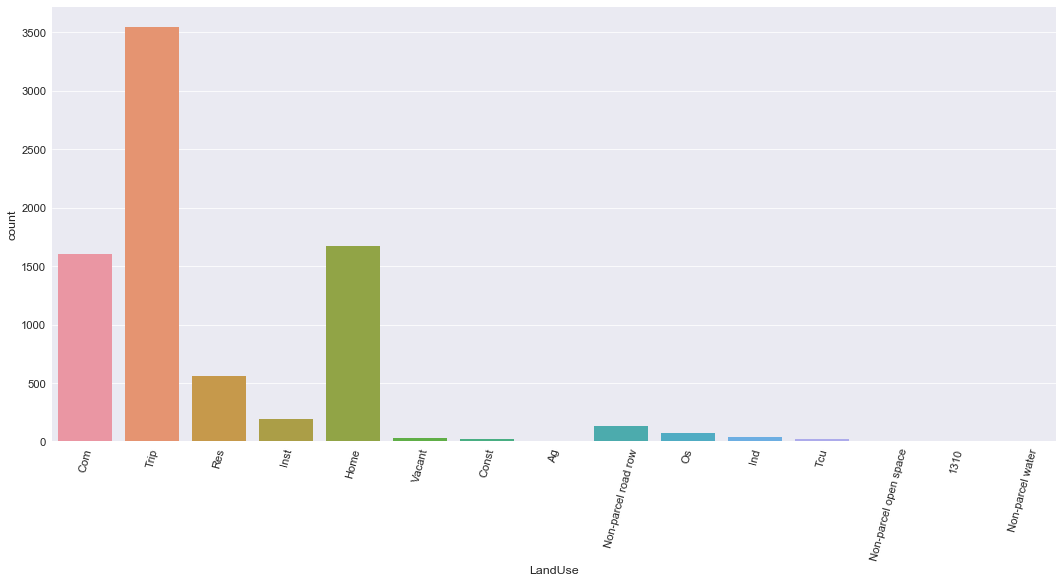

In [76]:
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
ax = sns.countplot(Data.LandUse)
ax = plt.xticks(rotation=75)

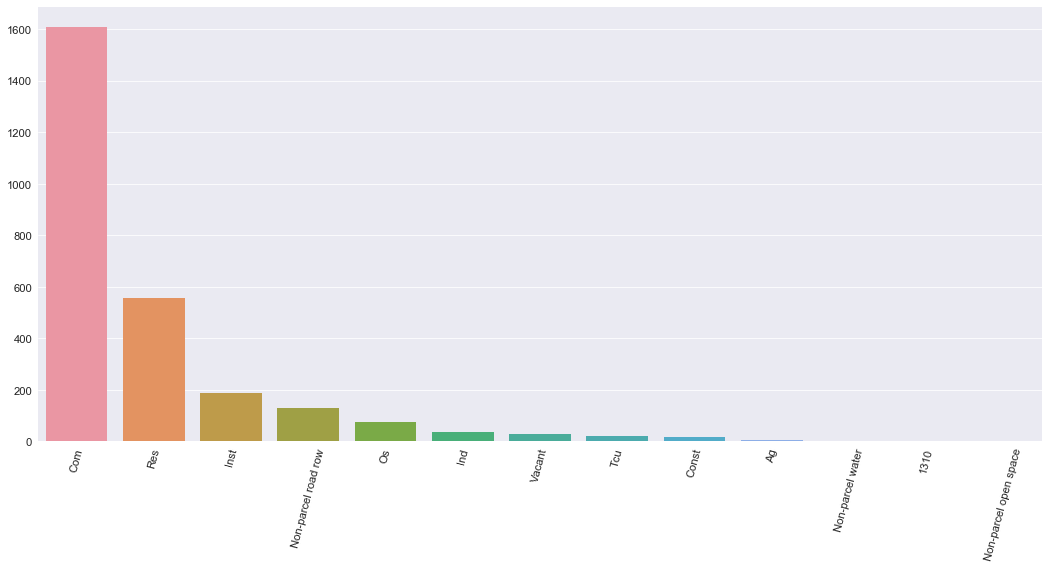

In [77]:
c = Data.LandUse.value_counts(normalize=False)
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
sns.barplot(x=c[2:].index,y=c[2:].values)
ax = plt.xticks(rotation=75)

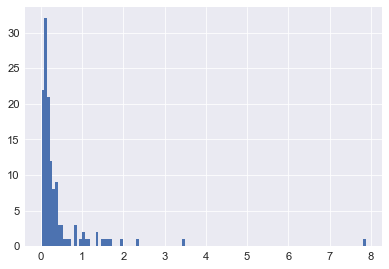

In [94]:
(Data[Data['LandUse']=='Non-parcel road row']['Duration']*24).hist(bins=120)

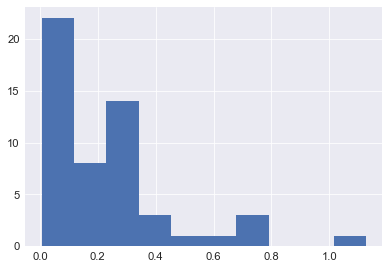

In [103]:
(Data[Data['Mode']=='Walk']['Duration']*24).hist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010FDAE80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015806588>], dtype=object)

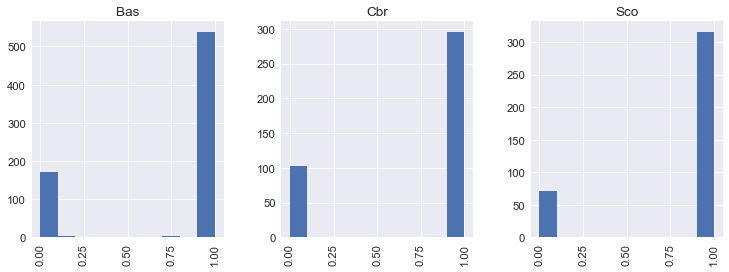

In [42]:
LocData = Data[(Data['LandUse']=='Com')]
LocData.hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C49E9B0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001318F160>], dtype=object)

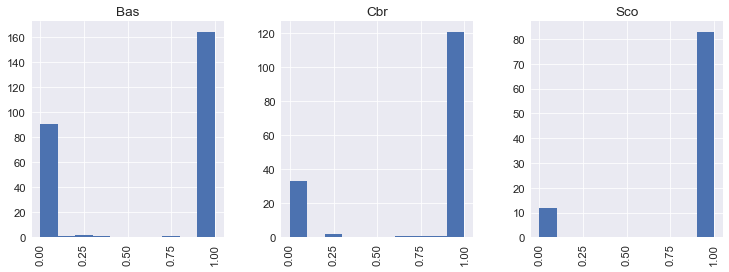

In [43]:
Data[(Data['LandUse']=='Res')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010915438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CDAE470>], dtype=object)

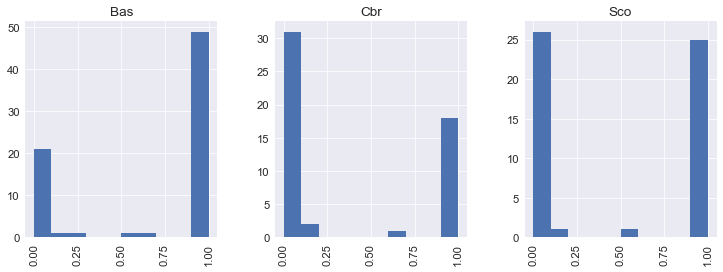

In [44]:
Data[(Data['LandUse']=='Inst')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012D8C6D8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D321A90>], dtype=object)

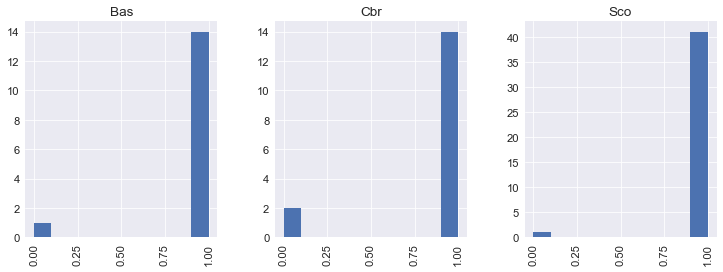

In [45]:
Data[(Data['LandUse']=='Os')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

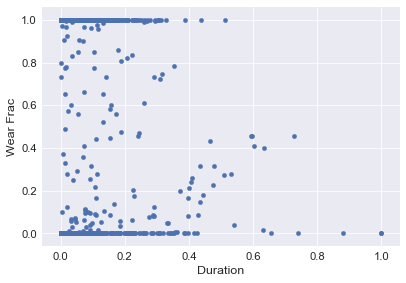

In [54]:
BraceData = Data[(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr'))]
ax = BraceData.plot(x='Duration',y='Wear Frac',kind='scatter')
# ax.set_xlim(-.1,10)

# Calculate Features

In [10]:
path_procfiles = os.path.join(path,'UIC_GPSData/w_LocIDandDist')

In [7]:
def getTripDur(PreDestInd,Data):
    d = Data[PreDestInd]
    TripDur=[]
    for i in range(len(d)):
        if d['LandUse'].as_matrix()[i]=='Trip':
            TripDur.append(d['Duration'].as_matrix()[i])
        else:
            TripDur.append(np.float('nan'))
            
    return pd.Series(TripDur)

In [78]:
Data = pd.DataFrame()
for f in os.listdir(path_procfiles):
#     print(f)
    if os.path.isfile(os.path.join(path_procfiles,f)):
        d = pd.read_csv(os.path.join(path_procfiles,f))
        d.LandUse = [x.split('_')[0] for x in d.LandUse]
        DestinationInd = (d['LandUse']!='Home')&(d['LandUse']!='Trip')
        # don't use first row as a destination
        if DestinationInd[0]:
            DestinationInd[0] = False
        
        del d['Unnamed: 0']
        del d['Unnamed: 0.1']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        
#         print(sum(DestinationInd), sum(d['LandUse']=='Trip'))
        
        # Calculate trip features
        PreDestInd = DestinationInd[1::]
        PreDestInd = PreDestInd.append(pd.Series(False)).as_matrix()
#         print(d[PreDestInd]['LandUse'].unique())

#         TripMode = pd.Series(np.float('nan')).append(d[PreDestInd]['Mode'])
        TripMode = d[PreDestInd]['Mode']
#         TripDuration = pd.Series(np.float('nan')).append(getTripDur(PreDestInd,d))
        TripDuration = getTripDur(PreDestInd,d)
        
        # Calculate aggregate features
        d = d[DestinationInd]
        d['Relative Freq'] = pd.Series([sum(d['LocID']==x)/sum(DestinationInd) for x in d['LocID']]).as_matrix()
        d['Relative Duration'] = pd.Series([sum(d[d['LocID']==x]['Duration'])/sum(d['Duration']) for x in d['LocID']]).as_matrix()
        d['TripMode'] = TripMode.as_matrix()
        d['TripDuration'] = TripDuration.as_matrix()
        Data = pd.concat([Data,d[1::]]) #concatenate data from each subj
    else:
        #skip directories
        continue

OtherDestInd = (Data['LandUse']!='Inst')&(Data['LandUse']!='Res')&(Data['LandUse']!='Com')&(Data['LandUse']!='Os')
Data.loc[OtherDestInd,'LandUse'] = 'Other'

In [79]:
Features = pd.DataFrame({'Wear Frac':np.array(Data['Wear Frac'])})

In [80]:
Features['DestinationType'] = Data['LandUse'].as_matrix()
Features['Distance'] = Data['DistHome'].as_matrix()
Features['Duration'] = (Data['Duration']*24).as_matrix()
Features['Mean Speed'] = Data['Speed_Mean'].as_matrix()
Features['TripMode'] = Data['TripMode'].as_matrix()
Features['TripDuration'] = Data['TripDuration'].as_matrix()
Features['Relative Freq'] = Data['Relative Freq'].as_matrix()
Features['Relative Duration'] = Data['Relative Duration'].as_matrix()

In [91]:
demographics = pd.read_excel('./Demographics_analysis.xlsx')
demographics.columns

Index(['SubjID', 'median WT CBR', 'median WT SCO', 'median WT Baseline',
       'med sph CBR', 'med sph SCO', 'med sph Baseline', 'y of baseline use',
       'Diagnosis', 'Short Diagnosis', 'Age', 'Ncluster CBR',
       'MeanAwayTime CBR', 'Away/Home Time CBR', 'Home_WT CBR', 'Away_WT CBR',
       'Ncluster SCO', 'MeanAwayTime SCO', 'Away/Home Time SCO', 'Home_WT SCO',
       'Away_WT SCO'],
      dtype='object')

In [93]:
Features['Age'] = [demographics[demographics['SubjID']==x]['Age'].values[0] for x in Data['SubjID']]
Features['Diagnosis'] = [demographics[demographics['SubjID']==x]['Short Diagnosis'].values[0] for x in Data['SubjID']]
Features['BaselineYrs'] = [demographics[demographics['SubjID']==x]['y of baseline use'].values[0] for x in Data['SubjID']]


In [107]:
ClinicalMeasures = ['6mwt', '10mwt_ss', '10mwt_fast']
for name in ClinicalMeasures:
    d = pd.read_csv('./Clinical Measures/'+name+'.csv')
    Features[name] = [d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

In [104]:
[d[d['SubjID']==x][y].values[0] for x, y in Data[['SubjID', 'Brace']].as_matrix()]

KeyError: 'Cbr'

In [108]:
Features.head()

,Wear Frac,DestinationType,Distance,Duration,Mean Speed,TripMode,TripDuration,Relative Freq,Relative Duration,Age,Diagnosis,BaselineYrs,6mwt,10mwt_ss,10mwt_fast
0,0.063091,Inst,6302.016284,1.758333,0.230411,Car,0.011921,0.014925,0.013607,65,poliomyelitis,60.0,231.93,0.69,0.85
1,0.000000,Com,5095.353084,1.016389,0.591493,Car,0.008218,0.014925,0.007865,65,poliomyelitis,60.0,231.93,0.69,0.85
2,0.000000,Com,5172.335257,0.366111,1.607549,Car,0.001505,0.029851,0.004252,65,poliomyelitis,60.0,231.93,0.69,0.85
3,0.000000,Com,2871.295912,0.052778,4.483316,Car,0.003704,0.044776,0.001827,65,poliomyelitis,60.0,231.93,0.69,0.85
4,0.000000,Com,2870.686716,0.033333,7.098997,Car,0.004514,0.044776,0.001827,65,poliomyelitis,60.0,231.93,0.69,0.85


## Time spent at home

In [15]:
Data['Brace'].unique()

array(['Cbr', 'Sco', 'Bas'], dtype=object)

In [21]:
durCbr = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durCbr=durCbr[~np.isnan(durCbr)]
durSCO = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durSCO=durSCO[~np.isnan(durSCO)]
durBase = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Bas')]['Duration']
durBase = np.asarray([float(x) for x in durBase.values if type(x) is float])
durBase=durBase[~np.isnan(durBase)]

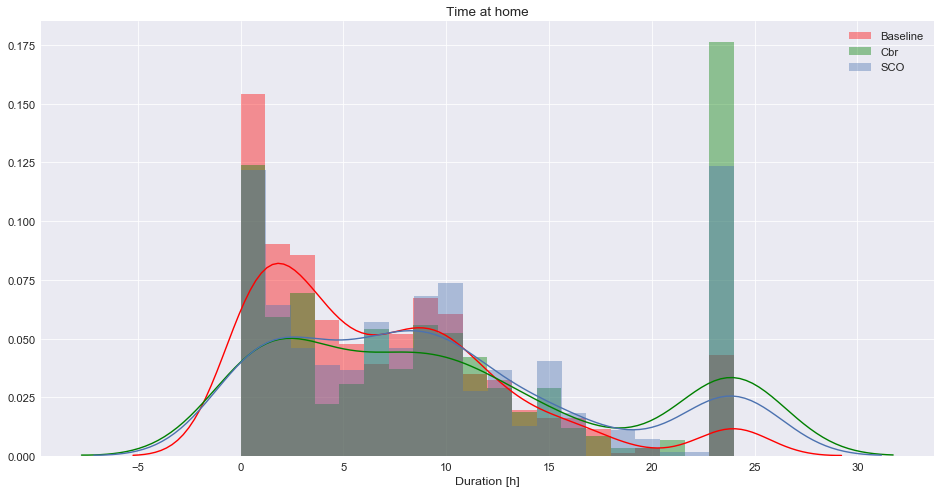

In [22]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase/60,color='r',bins=nb)
sns.distplot(durCbr/60,color='g',bins=nb)
sns.distplot(durSCO/60,bins=nb)
plt.xlabel('Duration [h]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at home')

## Time spent in trips

In [23]:
durCbr = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

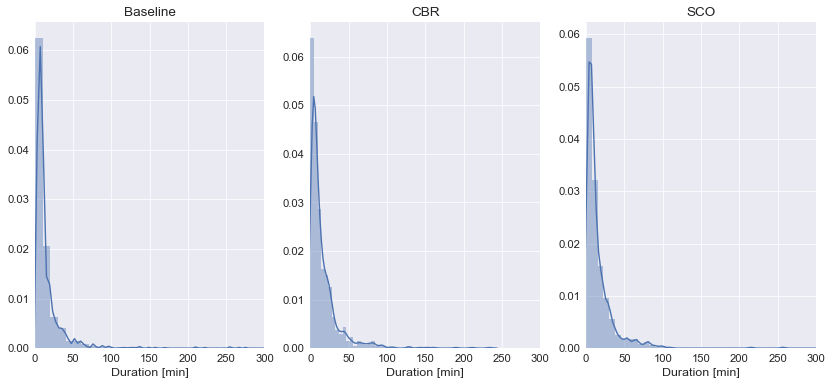

In [24]:
fig = plt.figure(figsize=(14,6))
fig.add_subplot(131)
ax = sns.distplot(durBase)
plt.xlim([0,300])
plt.title('Baseline')
plt.xlabel('Duration [min]')
fig.add_subplot(132)
ax = sns.distplot(durCbr)
plt.xlim([0,300])
plt.title('CBR')
plt.xlabel('Duration [min]')
fig.add_subplot(133)
ax = sns.distplot(durSCO)
plt.xlim([0,300])
plt.title('SCO')
plt.xlabel('Duration [min]')

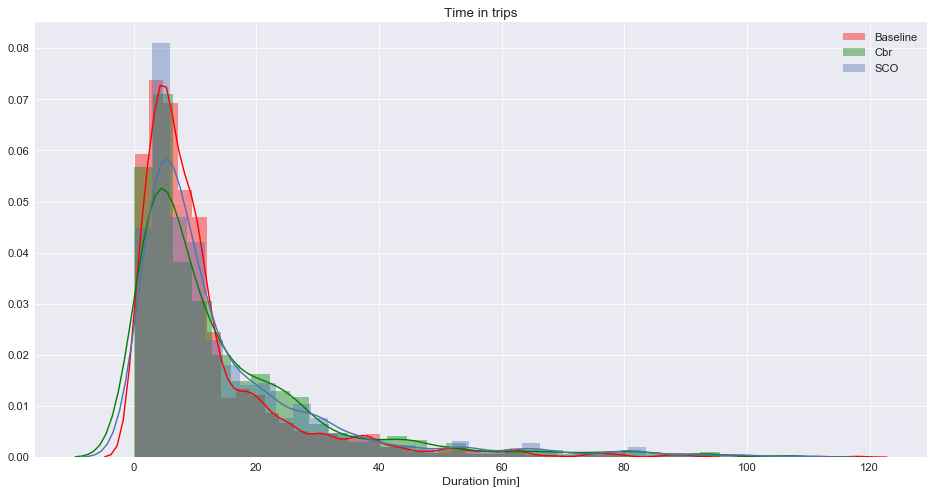

In [25]:
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<120],color='r')
sns.distplot(durCbr[durCbr<120],color='g')
sns.distplot(durSCO[durSCO<120])
plt.legend(['Baseline','Cbr','SCO'])
plt.xlabel('Duration [min]')
plt.title('Time in trips')

## Time spent at locations other than home and trip

In [26]:
durCbr = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

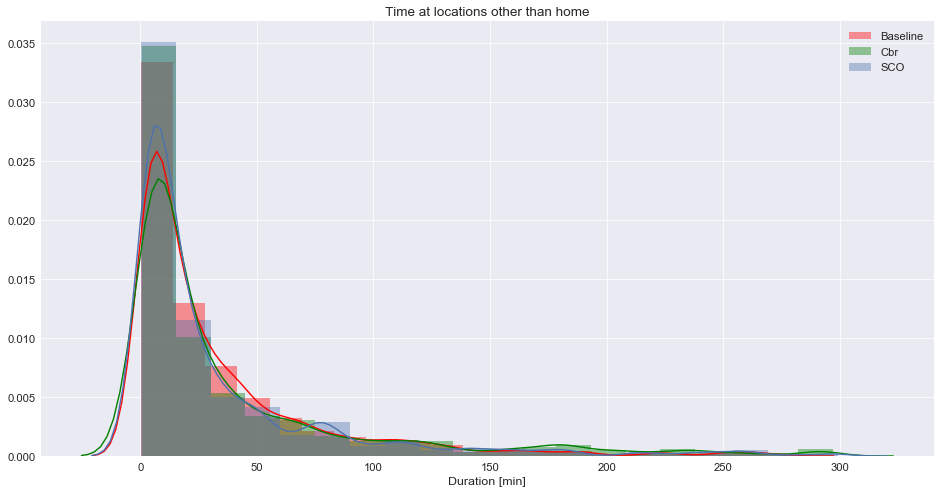

In [27]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<300],color='r',bins=nb)
sns.distplot(durCbr[durCbr<300],color='g',bins=nb)
sns.distplot(durSCO[durSCO<300],bins=nb)
plt.xlabel('Duration [min]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at locations other than home')

## Wear Fractions for each brace
* Proportion of trips w/wo brace
* Correlation of wearfrac and Trip duration

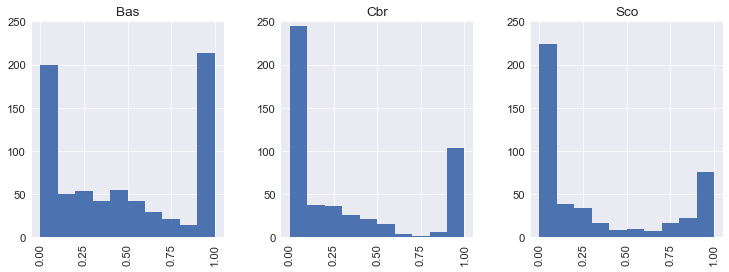

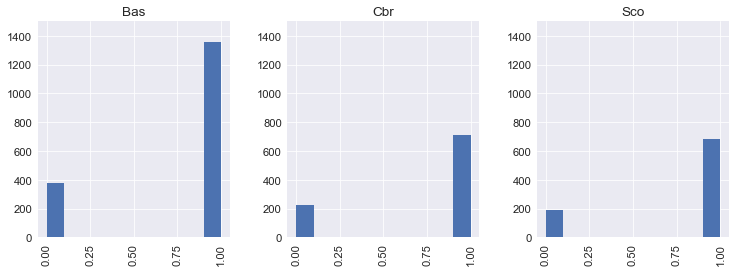

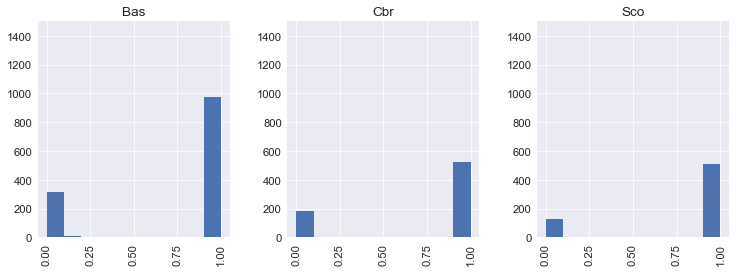

In [126]:
#wearfrac during trips,home and other use
ax = Data[(Data['LandUse']=='Home')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,250])
ax = Data[(Data['LandUse']=='Trip')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])
ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])

* Break the information for locations visited (neither home nor trip) by subject

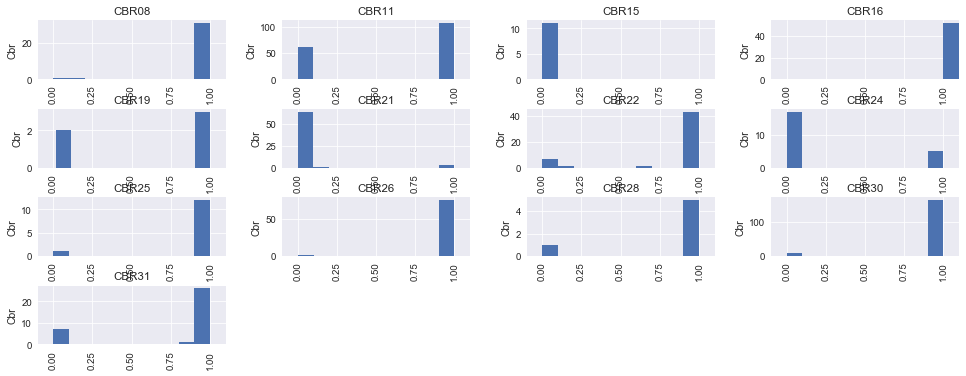

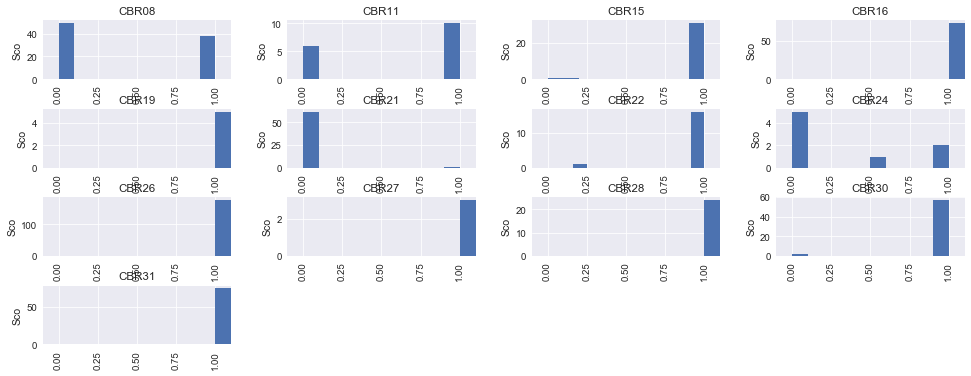

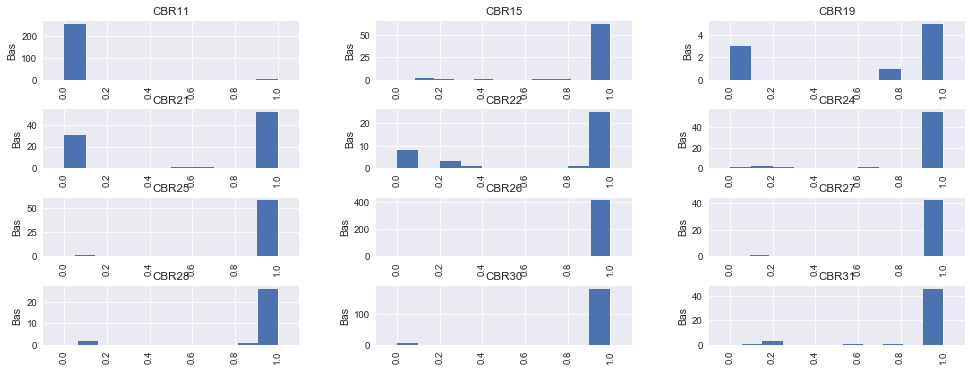

In [194]:
sns.set_context('paper',font_scale=1.2)
for brace in Data['Brace'].unique():
    ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']==brace)].hist(column='Wear Frac',by='SubjID',figsize=(16,6))
    for a in ax.reshape(-1):
        a.set_xlim([-0.1,1.1])
        a.set_ylabel(str(brace))

Half subjects were consistent at wearing each brace across all trials. 

# Do people travel further from home with the cbrace?
* Median distance from home with each brace

In [208]:
#plot test datapoint
import gmplot
gmap = gmplot.GoogleMapPlotter(41.75554804, -87.91244198, 16)
gmap.scatter([home[0],home[0]],[home[1],home[1]],'#3B0B39', size=100,marker=False)
gmap.draw("mymap.html")

In [541]:
??gmplot.GoogleMapPlotter

In [ ]:
#store distance of each location visited from home
distall = pd.Series()
for s in Data.SubjID.unique():
    
    #mean lat,lon home for subj
    homelat = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lat'].mean()
    homelon = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lon'].mean()
    Datai = Data.loc[Data['SubjID']==s]            
    print(s)
    #distance of all locations from home
    d = []
    for k in range(len(Datai)):
        lat = Datai.iloc[k]['Mean Lat']
        lon = Datai.iloc[k]['Mean Lon']
        try:
            d.append(vincenty((homelat,homelon),(lat,lon)).meters/1000)
        except(UnboundLocalError): #nan lat,lon
            print('found nan lat/lon')
            d.append(np.nan)
     
    print(len(d))
    
    #aggregate distances for all subjects
    distall = distall.append(pd.Series(data=d,index=Data.loc[Data['SubjID']==s]['SubjID']))

In [90]:
#assigning new index to df Data to match with Series
Data.index = distall.index
Data['DistanceHome'] = distall

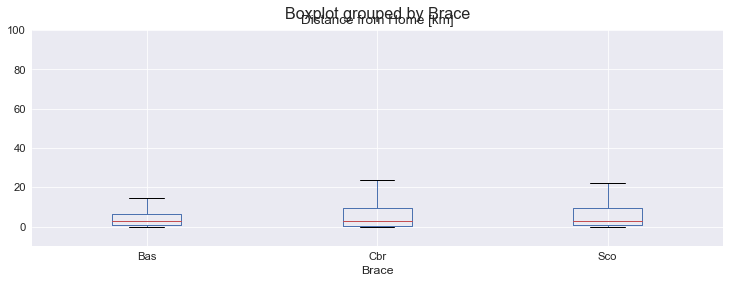

In [103]:
#plot distance from home for locations based on brace
ax2 = Data[~((Data['LandUse']=='Home')&(Data['LandUse']=='Trip'))].boxplot(column='DistanceHome',by='Brace',figsize=(12,4))
ax2.set_ylim([-10,100])
ax2.set_title('Distance from Home [km]')

## Distance traveled from home with each brace

In [ ]:
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']>0.75)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']<0.5)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])

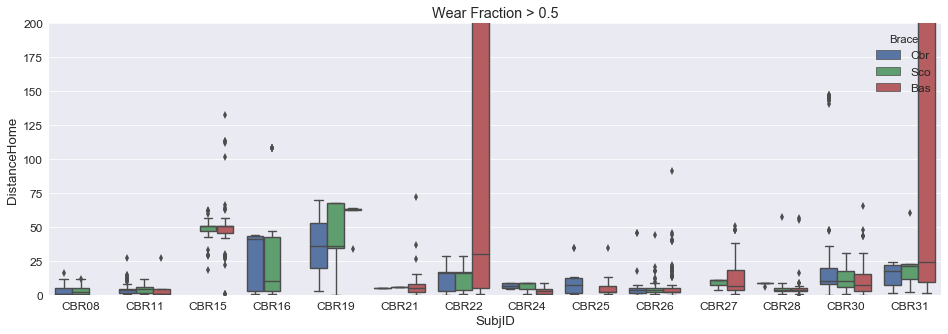

In [203]:
Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']>0.5)]
fig = plt.figure(figsize=(16,5))
# fig.add_subplot(211)
ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
ax.set_ylim([0,200])
plt.title('Wear Fraction > 0.5')
sns.set_context('paper',font_scale=1.5)

# Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']<0.5)]
# fig.add_subplot(212)
# ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
# ax.set_ylim([0,200])
# plt.title('Wear Fraction < 0.5')
# sns.set_context('paper',font_scale=1.5)

In [289]:
#plot locations visited by CBR22 and 31
s = 'CBR22'
d = Data.loc[(Data['SubjID']==s)]#&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))]
homelat = d[d['LandUse']=='Home']['Mean Lat'].mean()
homelon = d[d['LandUse']=='Home']['Mean Lon'].mean()
gmap = gmplot.GoogleMapPlotter(homelat, homelon, 16)

In [290]:
d = Data.loc[(Data['SubjID']==s)&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')]
for l in range(len(d)):
    lat = d.iloc[l]['Mean Lat']
    lon = d.iloc[l]['Mean Lon']
    ll = np.array([lat,lon])
    gmap.scatter([ll[0],ll[0]],[ll[1],ll[1]],'#3B0B39', size=200,marker=False)

gmap.draw("mymap.html")

# distinct locations visited per brace

In [11]:
fconv =  os.listdir(path+'GPSWT/')

for f in fconv:
    print(f)
    Data = pd.read_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    # needs to be capitalized to standardize text
    landuse=Data[['LandUse']]
    landuse=landuse.applymap(lambda x: str.capitalize(x))
    Data['LandUse'] = landuse
    
    # find mean Home location
    HomeInd = Data['LandUse']=='Home'
    HomeLon = np.nanmean(Data['Mean Lon'][HomeInd])
    HomeLat = np.nanmean(Data['Mean Lat'][HomeInd])
    
    # identify unique locations (>100m apart)
    
    threshold = 50
    
    UnDestLon = []
    UnDestLat = []
    UnDestDist = []
    
    LocID = []
    DistHome = []
    
    for row in range(len(Data)):
        if (Data['LandUse'][row]!='Home')&(Data['LandUse'][row]!='Trip'): # should be non-Home, non-Trip
            lon = Data['Mean Lon'][row]
            lat = Data['Mean Lat'][row]
            d = vincenty((HomeLat,HomeLon),(lat,lon)).meters
            DistHome.append(d)
            if d<=threshold:
                # Ideally, d threshold should be small enough to separate locations near home
                # Flag failures to do this for now to see how often it happens
                print('Error: Non-Home Destination Near Home')
                print(Data['LandUse'][row])
                print(d)
                LocID.append(-2)
            else:
                if len(UnDestLon)<1: # Initial destination
                    UnDestLon.append(lon); UnDestLat.append(lat)
                    LocID.append(1)
                else: # After first location is ID'd check to see if other destinations are unique
                    i = 0; Unlabeled = True
                    while Unlabeled & (i<len(UnDestLat)):
                        d = vincenty((UnDestLat[i],UnDestLon[i]),(lat,lon)).meters
                        if d<=threshold:
                            Unlabeled = False
                            LocID.append(i+1)
                            # may want to consider adjusting mean location for the destination based on new trip
                        else:
                            i=i+1
                    if i==len(UnDestLat):
                        UnDestLon.append(lon); UnDestLat.append(lat); UnDestDist.append(d)
                        LocID.append(i+1)
        else:
            # Special cases for Home and Trip data
            if Data['LandUse'][row]=='Home':
                LocID.append(0)
                DistHome.append(0)
            else:
                LocID.append(-1)
                DistHome.append(-1)
                
    Data['LocID'] = pd.Series(LocID)
    Data['DistHome']  = pd.Series(DistHome)
    
    Data.to_csv(path+'UIC_GPSData/w_LocIDandDist/'+f)
                    
                            
                        
                    
    

CBR08_CBrace.csv
CBR08_SCO.csv
CBR11_Baseline.csv
CBR11_CBrace.csv
CBR11_SCO.csv
CBR15_Baseline.csv
CBR15_CBrace.csv
CBR15_SCO.csv
CBR16_CBrace.csv
CBR16_SCO.csv
CBR19_Baseline.csv
CBR19_CBrace.csv
CBR19_SCO.csv
Error: Non-Home Destination Near Home
Com_regional
9.55765950374758
CBR21_Baseline.csv
CBR21_CBrace.csv
CBR21_SCO.csv
CBR22_Baseline.csv
CBR22_CBrace.csv
CBR22_SCO.csv
CBR24_Baseline.csv
CBR24_CBrace.csv
CBR24_SCO.csv
CBR25_Baseline.csv
CBR25_CBrace.csv
CBR26_Baseline.csv
CBR26_CBrace.csv
CBR26_SCO.csv
CBR27_Baseline.csv
CBR27_CBrace.csv
CBR27_SCO.csv
CBR28_Baseline.csv
CBR28_CBrace.csv
CBR28_SCO.csv
CBR30_Baseline.csv
CBR30_CBrace.csv
CBR30_SCO.csv
CBR31_Baseline.csv
CBR31_CBrace.csv
CBR31_SCO.csv
